Comparação Regressão Logística com seleção de features

In [1]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn

from sklearn.dummy import DummyClassifier
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif
from sklearn.linear_model import Perceptron, LogisticRegression, SGDClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, PowerTransformer

from src.auxiliares import dataframe_coeficientes
from src.config import DADOS_LIMPOS, MODELO_LINEAR_REGRESSION_REDUCAO_FEATURES
from src.graficos import plot_coeficientes, plot_comparar_metricas_modelos
from src.models import RANDOM_STATE
from src.models import (
    grid_search_cv_classificador,
    treinar_e_validar_modelo_classificacao,
    organiza_resultados,
)

#pandas configurando para mostrar todas as linhas e colunas
pd.set_option ('display.max_columns', None)

#configurando pandas para não mostrar notação científica
pd.set_option('display.float_format', lambda x: '%.2f' % x)


sns.set_theme(palette='viridis_r')

In [2]:
# Carregamento e preparação dos dados
df = pd.read_parquet(DADOS_LIMPOS)

df.head()

,area_mean,area_se,area_worst,compactness_mean,compactness_se,compactness_worst,concave points_mean,concave points_se,concave points_worst,concavity_mean,concavity_se,concavity_worst,diagnosis,fractal_dimension_mean,fractal_dimension_se,fractal_dimension_worst,perimeter_mean,perimeter_se,perimeter_worst,radius_mean,radius_se,radius_worst,smoothness_mean,smoothness_se,smoothness_worst,symmetry_mean,symmetry_se,symmetry_worst,texture_mean,texture_se,texture_worst
0,1001.00,153.40,2019.00,0.28,0.05,0.67,0.15,0.02,0.27,0.30,0.05,0.71,M,0.08,0.01,0.12,122.80,8.59,184.60,17.99,1.09,25.38,0.12,0.01,0.16,0.24,0.03,0.46,10.38,0.91,17.33
1,1326.00,74.08,1956.00,0.08,0.01,0.19,0.07,0.01,0.19,0.09,0.02,0.24,M,0.06,0.00,0.09,132.90,3.40,158.80,20.57,0.54,24.99,0.08,0.01,0.12,0.18,0.01,0.28,17.77,0.73,23.41
2,1203.00,94.03,1709.00,0.16,0.04,0.42,0.13,0.02,0.24,0.20,0.04,0.45,M,0.06,0.00,0.09,130.00,4.58,152.50,19.69,0.75,23.57,0.11,0.01,0.14,0.21,0.02,0.36,21.25,0.79,25.53
3,386.10,27.23,567.70,0.28,0.07,0.87,0.11,0.02,0.26,0.24,0.06,0.69,M,0.10,0.01,0.17,77.58,3.44,98.87,11.42,0.50,14.91,0.14,0.01,0.21,0.26,0.06,0.66,20.38,1.16,26.50
4,1297.00,94.44,1575.00,0.13,0.02,0.20,0.10,0.02,0.16,0.20,0.06,0.40,M,0.06,0.01,0.08,135.10,5.44,152.20,20.29,0.76,22.54,0.10,0.01,0.14,0.18,0.02,0.24,14.34,0.78,16.67


In [3]:
X= df.drop(columns=['diagnosis'])
y= df['diagnosis']

In [4]:
# Codificação da variável target (B=0, M=1)
le =LabelEncoder()

y=le.fit_transform(y)


In [5]:
le.classes_

array(['B', 'M'], dtype=object)

In [6]:
#seleção de features
selector_mi = SelectKBest(mutual_info_classif, k=15)
X_mi = selector_mi.fit_transform(X,y) 
X_mi.shape

(569, 15)

In [7]:
selector_mi.get_feature_names_out()

array(['area_mean', 'area_se', 'area_worst', 'compactness_mean',
       'compactness_worst', 'concave points_mean', 'concave points_worst',
       'concavity_mean', 'concavity_worst', 'perimeter_mean',
       'perimeter_se', 'perimeter_worst', 'radius_mean', 'radius_se',
       'radius_worst'], dtype=object)

In [8]:
selector_mi.scores_

array([0.36076997, 0.34171866, 0.46367864, 0.21212171, 0.07569998,
       0.22610924, 0.44122297, 0.12970679, 0.43682569, 0.3745765 ,
       0.11744773, 0.31575316, 0.00678742, 0.03863905, 0.0687569 ,
       0.40032755, 0.27601714, 0.47396184, 0.36927425, 0.24946172,
       0.45166903, 0.08424476, 0.01513245, 0.10025368, 0.05928549,
       0.0133485 , 0.09494465, 0.10099014, 0.        , 0.11988462])

In [9]:
selector_mi.pvalues_

In [10]:
selector_mi.get_support()

array([ True,  True,  True,  True, False,  True,  True, False,  True,
        True, False,  True, False, False, False,  True,  True,  True,
        True,  True,  True, False, False, False, False, False, False,
       False, False, False])

In [11]:
features = pd.DataFrame(
    {
        'mi':selector_mi.get_support(),
    },
    index = X.columns,
)
features

,mi
area_mean,True
area_se,True
area_worst,True
compactness_mean,True
compactness_se,False
compactness_worst,True
concave points_mean,True
concave points_se,False
concave points_worst,True
concavity_mean,True


In [12]:
# Estratificação para validação cruzada
kf= StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)


In [13]:
# Pipeline de pré-processamento (PowerTransformer para dados assimétricos)
preprocessamento = Pipeline(
    steps=[
        ("scaler", PowerTransformer()), 
        ("selector", SelectKBest(mutual_info_classif, k=15))
    ]
)


In [14]:
#comparação dos modelos
classificadores = {
    'DummyClassifier':{
        'preprocessor': None,
        'classificador': DummyClassifier(strategy='stratified')
    },

  
      'LogisticRegression':{
        'preprocessor': preprocessamento,
        'classificador': LogisticRegression()
    },

    'SGDClassifier':{
        'preprocessor': preprocessamento,
        'classificador': SGDClassifier()
    },

}


In [15]:
resultados = {
    nome_modelo: treinar_e_validar_modelo_classificacao(X, y, kf, **classificador)
    for nome_modelo, classificador in classificadores.items()
}
df_resultados = organiza_resultados(resultados)
df_resultados


,model,fit_time,score_time,test_accuracy,test_balanced_accuracy,test_f1,test_precision,test_recall,test_roc_auc,test_average_precision,test_f2_score,time_seconds
0,DummyClassifier,0.00,0.02,0.57,0.54,0.44,0.43,0.44,0.53,0.39,0.44,0.02
1,DummyClassifier,0.00,0.02,0.47,0.45,0.33,0.32,0.35,0.50,0.38,0.34,0.02
2,DummyClassifier,0.00,0.02,0.56,0.54,0.43,0.41,0.45,0.49,0.36,0.44,0.02
3,DummyClassifier,0.00,0.02,0.54,0.48,0.31,0.34,0.29,0.48,0.36,0.30,0.02
4,DummyClassifier,0.00,0.02,0.59,0.56,0.45,0.45,0.45,0.47,0.36,0.45,0.02
5,LogisticRegression,0.20,0.02,0.97,0.98,0.97,0.93,1.00,1.00,1.00,0.99,0.22
6,LogisticRegression,0.19,0.02,0.95,0.93,0.93,0.97,0.88,0.99,0.98,0.90,0.21
7,LogisticRegression,0.18,0.02,0.93,0.92,0.90,0.93,0.88,0.98,0.98,0.89,0.19
8,LogisticRegression,0.17,0.02,0.94,0.94,0.92,0.89,0.95,0.99,0.99,0.94,0.19
9,LogisticRegression,0.17,0.02,0.97,0.96,0.96,1.00,0.93,1.00,1.00,0.94,0.19


In [16]:
#O F2-score foi usado como métrica principal por dar mais peso ao recall
df_resultados.groupby('model').mean().sort_values('test_f2_score')

,fit_time,score_time,test_accuracy,test_balanced_accuracy,test_f1,test_precision,test_recall,test_roc_auc,test_average_precision,test_f2_score,time_seconds
model,,,,,,,,,,,
DummyClassifier,0.00,0.02,0.55,0.52,0.39,0.39,0.40,0.49,0.37,0.39,0.02
LogisticRegression,0.18,0.02,0.95,0.95,0.94,0.94,0.93,0.99,0.99,0.93,0.20
SGDClassifier,0.16,0.02,0.95,0.95,0.93,0.92,0.94,0.99,0.98,0.94,0.18


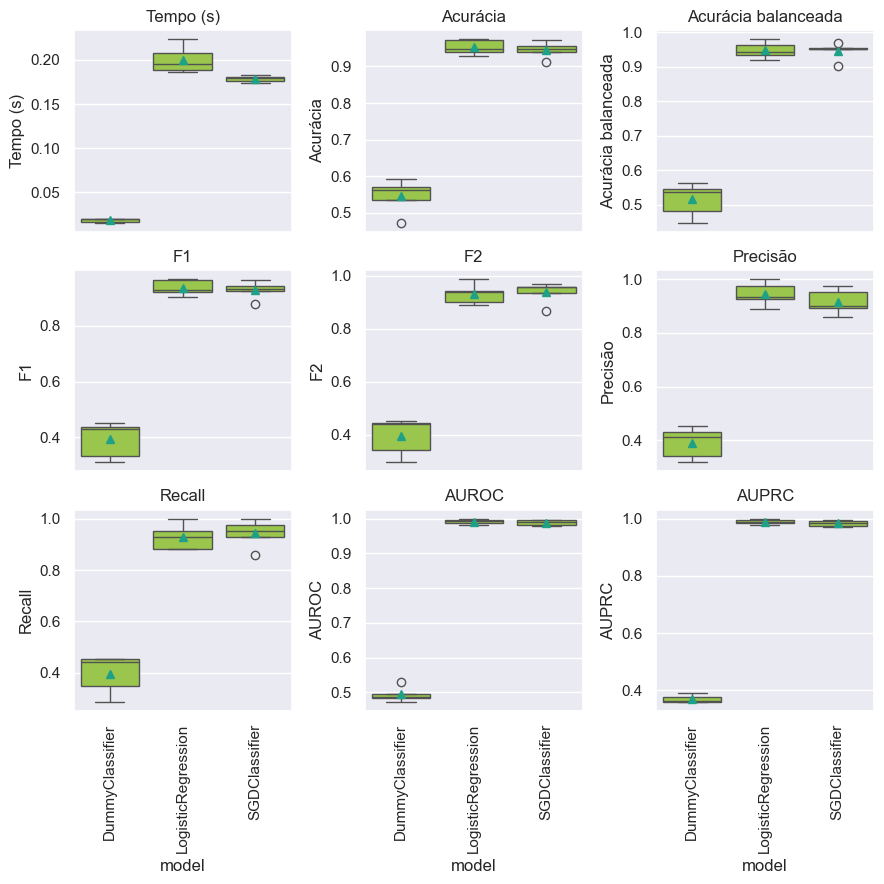

In [17]:
plot_comparar_metricas_modelos(df_resultados)

In [18]:
#otimização de hiperparâmetros

param_grid= {
    "clf__C":[0.1, 1, 10, 100],
    "clf__penalty": ['l2', 'l1'],
    'clf__class_weight':[None, 'balanced'],
    'clf__solver': ['liblinear','saga'],
}


In [19]:
clf = LogisticRegression(random_state=RANDOM_STATE)
grid_search = grid_search_cv_classificador(
    clf, param_grid, kf, preprocessamento, refit_metric="f2_score"
)
grid_search


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        Pipeline(steps=[('scaler',
                                                         PowerTransformer()),
                                                        ('selector',
                                                         SelectKBest(k=15,
                                                                     score_func=<function mutual_info_classif at 0x000002E6CA2BCA40>))])),
                                       ('clf',
                                        LogisticRegression(random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__C': [0.1, 1, 10, 100],
                         'c...
                         'clf__penalty': ['l2', 'l1'],
                         'clf__solver': ['liblinear', 'saga']},
             refit='f2_score',
             scoring={'accuracy': 'accuracy',
                      'average_precision': 'average_precision',
                      'balanced_accuracy': 'balanced_accuracy', 'f1': 'f1',
                      'f2_score': make_scorer(fbeta_score, response_method='predict', beta=2, average=binary),
                      'precision': 'precision', 'recall': 'recall',
                      'roc_auc': 'roc_auc'},
             verbose=1)

In [20]:
grid_search.fit(X,y)


Fitting 5 folds for each of 32 candidates, totalling 160 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        Pipeline(steps=[('scaler',
                                                         PowerTransformer()),
                                                        ('selector',
                                                         SelectKBest(k=15,
                                                                     score_func=<function mutual_info_classif at 0x000002E6CA2BCA40>))])),
                                       ('clf',
                                        LogisticRegression(random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__C': [0.1, 1, 10, 100],
                         'c...
                         'clf__penalty': ['l2', 'l1'],
                         'clf__solver': ['liblinear', 'saga']},
             refit='f2_score',
             scoring={'accuracy': 'accuracy',
                      'average_precision': 'average_precision',
                      'balanced_accuracy': 'balanced_accuracy', 'f1': 'f1',
                      'f2_score': make_scorer(fbeta_score, response_method='predict', beta=2, average=binary),
                      'precision': 'precision', 'recall': 'recall',
                      'roc_auc': 'roc_auc'},
             verbose=1)

In [21]:
grid_search.best_params_


{'clf__C': 10,
 'clf__class_weight': 'balanced',
 'clf__penalty': 'l2',
 'clf__solver': 'liblinear'}

In [22]:
grid_search.best_score_

0.9493139072895005

In [23]:
grid_search.best_estimator_


Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('scaler', PowerTransformer()),
                                 ('selector',
                                  SelectKBest(k=15,
                                              score_func=<function mutual_info_classif at 0x000002E6CA2BCA40>))])),
                ('clf',
                 LogisticRegression(C=10, class_weight='balanced',
                                    random_state=42, solver='liblinear'))])

In [24]:
#estudo de coeficientes
grid_search.best_estimator_['preprocessor'].get_feature_names_out()


array(['area_mean', 'area_se', 'area_worst', 'compactness_mean',
       'compactness_worst', 'concave points_mean', 'concave points_worst',
       'concavity_mean', 'concavity_worst', 'perimeter_mean',
       'perimeter_se', 'perimeter_worst', 'radius_mean', 'radius_se',
       'radius_worst'], dtype=object)

In [25]:
#estudo de coeficientes
grid_search.best_estimator_['clf'].coef_


array([[-1.50224425,  2.76597193,  2.85104211, -2.75369632,  0.78357933,
         3.73277235,  0.75584697, -0.78916064,  2.04345108, -0.66431963,
        -0.63582526,  1.51276504, -1.95163267, -0.26861962,  1.70830692]])

In [26]:
coefs = dataframe_coeficientes(
    grid_search.best_estimator_['clf'].coef_[0],
    grid_search.best_estimator_['preprocessor'].get_feature_names_out() #o nome das features
)
coefs 


,coeficiente
compactness_mean,-2.75
radius_mean,-1.95
area_mean,-1.50
concavity_mean,-0.79
perimeter_mean,-0.66
perimeter_se,-0.64
radius_se,-0.27
concave points_worst,0.76
compactness_worst,0.78
perimeter_worst,1.51


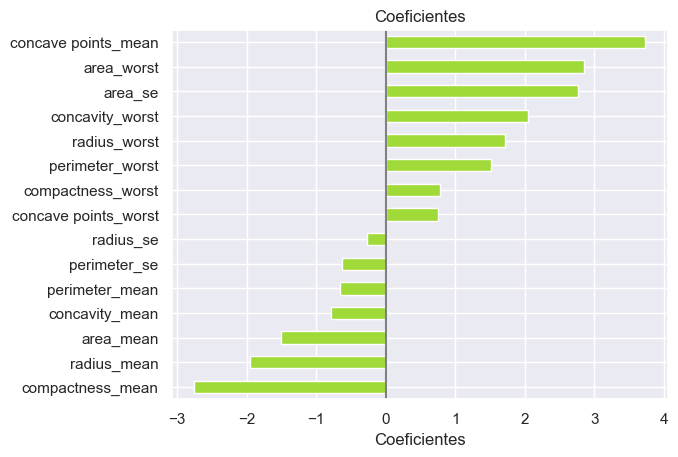

In [27]:
plot_coeficientes(coefs)

In [28]:
coefs_odds = coefs.copy()
coefs_odds['coeficiente'] = np.exp(coefs['coeficiente'])

coefs_odds


,coeficiente
compactness_mean,0.06
radius_mean,0.14
area_mean,0.22
concavity_mean,0.45
perimeter_mean,0.51
perimeter_se,0.53
radius_se,0.76
concave points_worst,2.13
compactness_worst,2.19
perimeter_worst,4.54


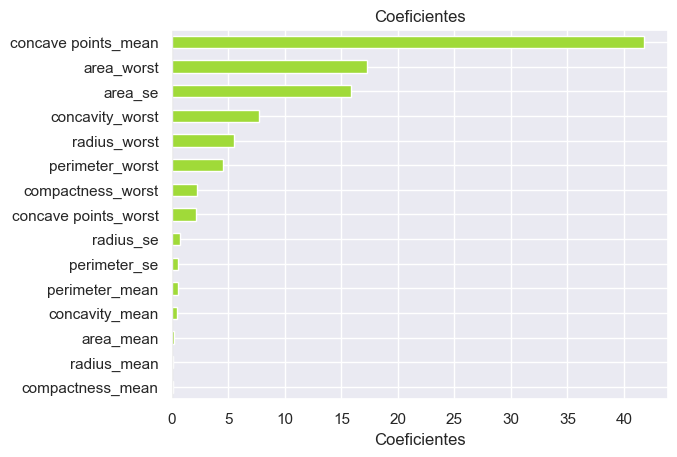

In [29]:
plot_coeficientes(coefs_odds)  

In [30]:
#avalaiar como o preprocessamento afetou as features e como está relacionado com os coeficientes
X_scaled = grid_search.best_estimator_['preprocessor'].transform(X)

X_scaled = pd.DataFrame(X_scaled, columns=grid_search.best_estimator_['preprocessor'].get_feature_names_out())
X_scaled.head()

,area_mean,area_se,area_worst,compactness_mean,compactness_worst,concave points_mean,concave points_worst,concavity_mean,concavity_worst,perimeter_mean,perimeter_se,perimeter_worst,radius_mean,radius_se,radius_worst
0,1.13,1.88,1.65,2.17,1.94,1.85,1.94,1.86,1.73,1.26,1.97,1.81,1.13,1.89,1.62
1,1.63,1.28,1.61,-0.38,-0.30,0.82,1.10,0.29,0.07,1.53,0.73,1.43,1.62,0.96,1.58
2,1.46,1.50,1.43,1.16,1.21,1.68,1.72,1.40,1.01,1.45,1.21,1.32,1.46,1.46,1.42
3,-0.84,0.05,-0.44,2.20,2.28,1.42,1.86,1.64,1.68,-0.51,0.76,-0.04,-0.76,0.79,-0.08
4,1.60,1.50,1.31,0.76,-0.13,1.41,0.81,1.41,0.82,1.58,1.45,1.32,1.57,1.48,1.29


In [31]:
#juntar com y para analisar o boxplot como feito no EDA. y está como array, precisamos transformar em y
df_scaled = pd.concat([X_scaled, pd.Series(y, name='diagnosis')], axis=1)
df_scaled.head()

,area_mean,area_se,area_worst,compactness_mean,compactness_worst,concave points_mean,concave points_worst,concavity_mean,concavity_worst,perimeter_mean,perimeter_se,perimeter_worst,radius_mean,radius_se,radius_worst,diagnosis
0,1.13,1.88,1.65,2.17,1.94,1.85,1.94,1.86,1.73,1.26,1.97,1.81,1.13,1.89,1.62,1
1,1.63,1.28,1.61,-0.38,-0.30,0.82,1.10,0.29,0.07,1.53,0.73,1.43,1.62,0.96,1.58,1
2,1.46,1.50,1.43,1.16,1.21,1.68,1.72,1.40,1.01,1.45,1.21,1.32,1.46,1.46,1.42,1
3,-0.84,0.05,-0.44,2.20,2.28,1.42,1.86,1.64,1.68,-0.51,0.76,-0.04,-0.76,0.79,-0.08,1
4,1.60,1.50,1.31,0.76,-0.13,1.41,0.81,1.41,0.82,1.58,1.45,1.32,1.57,1.48,1.29,1


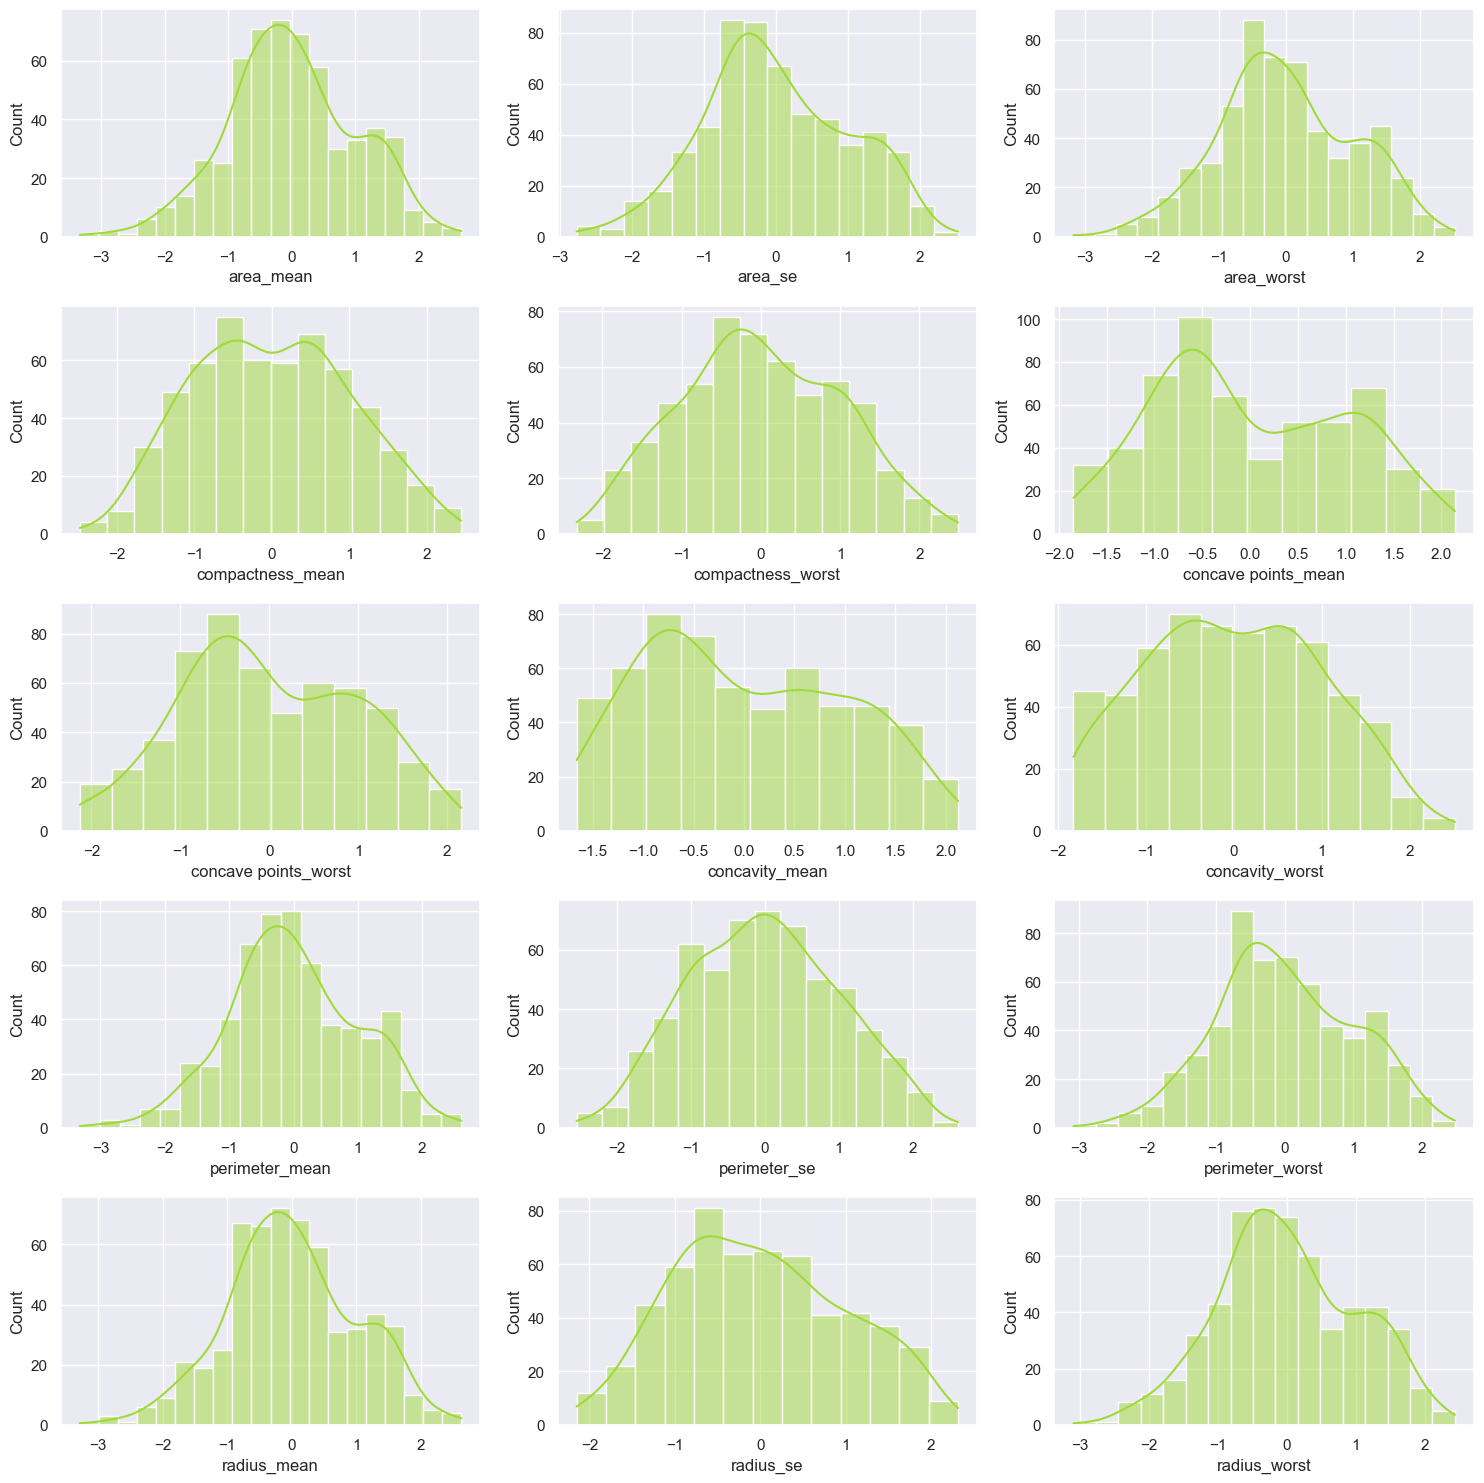

In [32]:
fig, axs = plt.subplots(5,3, figsize = (15,15))
for ax, coluna in zip(axs.flatten(), df_scaled.select_dtypes('number').columns):
    sns.histplot(x=coluna, ax=ax, data=df_scaled, kde=True)
    
plt.tight_layout()
plt.show()

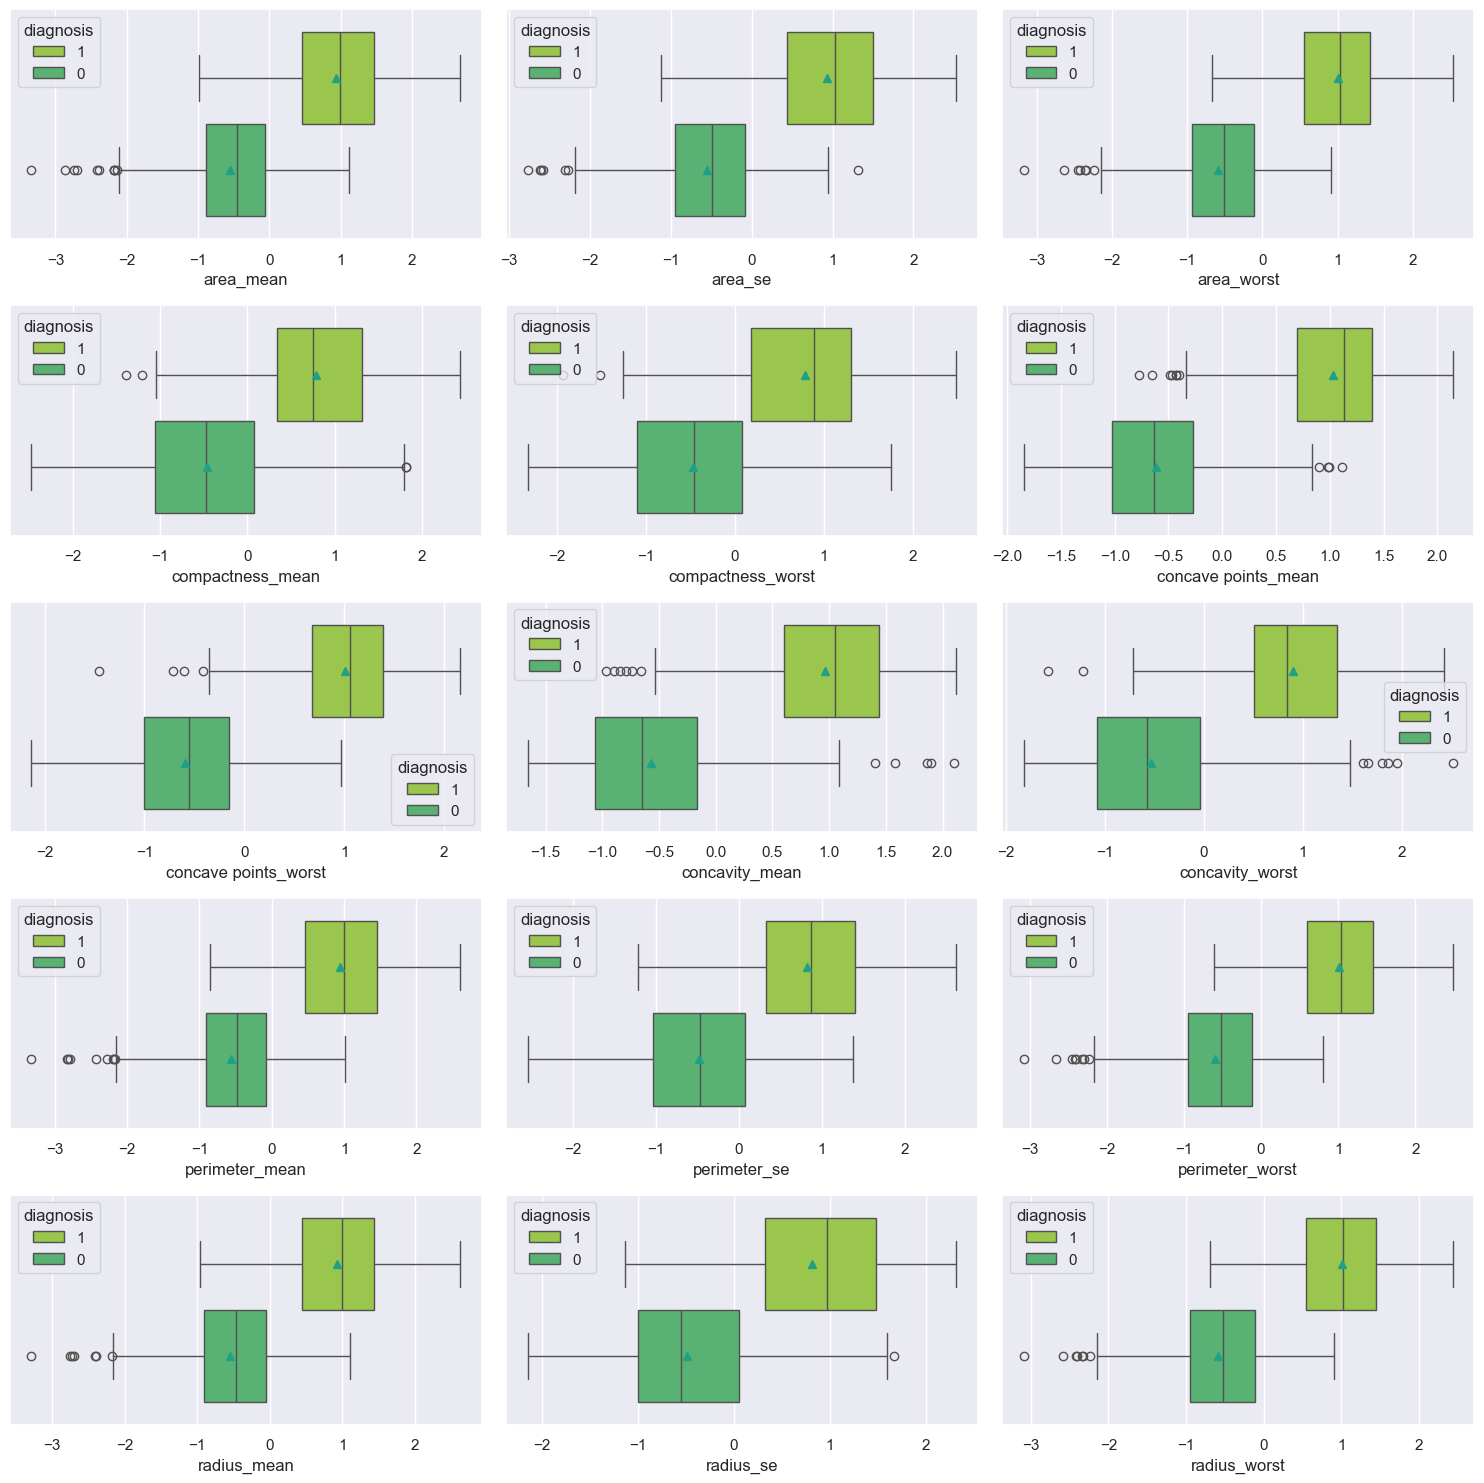

In [33]:
fig, axs = plt.subplots(5,3, figsize = (15,15))
for ax, coluna in zip(axs.flatten(), df_scaled.columns):
    sns.boxplot(x=coluna, ax=ax, data=df_scaled, showmeans=True, hue='diagnosis', hue_order=[1, 0])#inverter a ordem do hue, para compararmos com o gráfico eda
    
plt.tight_layout()
plt.show()

In [34]:
joblib.dump(grid_search, MODELO_LINEAR_REGRESSION_REDUCAO_FEATURES)

['D:\\ciencias_dados\\python_pratica\\hashtag\\ciencias_dados\\machine_learning\\comparativo_diversos_modelos_classificação\\modelos\\lr_red_feat.pkl']

### Conclusão

Esta análise aprimorada incorporou seleção rigorosa de features mantendo a metodologia central da abordagem inicial para identificar as 15 features mais preditivas dentre as 30 originais.

Principais achados:

A seleção de features manteve a performance do modelo (95% de acurácia) com redução de 50% na dimensionalidade

O método de informação mútua forneceu o conjunto de features mais interpretável clinicamente

As principais features preditivas (concave_points_mean, area_worst, area_se) mostraram notável consistência com conhecimento clínico

Nosso pipeline de pré-processamento normalizou as distribuições preservando sinais preditivos críticos

A análise de importância revelou:

concave_points_mean aumenta chances de malignidade em 41x (OR=41.79)

area_worst aumenta em 17x (OR=17.31)

area_se aumenta em 15x (OR=15.89)




## Conclusion
This enhanced analysis incorporated rigorous feature selection while maintaining the core methodology of the initial modeling approach. It was identified the 15 most predictive features from the original set of 30.

Key findings:

Feature selection maintained model performance (95% accuracy) while reducing dimensionality by 50%

The mutual information method provided the most biologically interpretable feature set

Top predictive features (concave_points_mean, area_worst, area_se) showed remarkable consistency with clinical knowledge

Our preprocessing pipeline successfully normalized distributions while preserving critical predictive signals

The feature importance analysis revealed:

concave_points_mean increases malignancy odds by 41x (OR=41.79)

area_worst increases odds by 17x (OR=17.31)

area_se increases odds by 15x (OR=15.89)